In [1]:
import awkward as ak
from collections import defaultdict
import math
import numpy as np
from coffea import util

from hist import Hist
import hist

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

# Compute JES

In [2]:
isData = False
isCHS = True
    
filename = "jes_QCD_PT-15to7000_TuneCP5_13p6TeV_pythia8.coffea"
        
print("Reading... ", filename)
output = util.load(filename)[0]

Reading...  jes_QCD_PT-15to7000_TuneCP5_13p6TeV_pythia8.coffea


In [3]:
colours = {
    "scouting" : "black", #"#FF66FF",
    "offline" : "red", #"#FF9900",
    "gen" : "#9A32CD",
}

colours_eta = {
    0 : "black", #"#FF66FF",
    1 : "red", #"#FF9900",
    sum : '#9A32CD',
}

marker = {
    "scouting" : "o",
    "offline" : "^",
    "gen" : "#9A32CD",
}

marker_eta = {
    0 : "o",
    1 : "^",
    sum : "#9A32CD",
}

eta = {
    0 : "barrel",
    1 : "endcap"
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'elinewidth': 1,
}

label = {
    0 : r"$|\eta| \leq 1.3$",
    1 : r"$1.3 < |\eta| \leq 2.5$",
    sum : r"$|\eta| \leq 2.5$",
}

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        
    return err

In [4]:
_triggers = {
    (85, 115) : ['L1_SingleJet60', 'HLT_PFJet60', 'HLT_PFJet80'],
    (115, 145) : ['L1_SingleJet90'],
    (145, 165) : ['L1_SingleJet120'],
    (165, 210) : ['HLT_PFJet140'],
    (210, 230) : ['L1_SingleJet180'],
    (230, 295) : ['L1_SingleJet200', 'HLT_PFJet200'],
    (295, 360) : ['HLT_PFJet260'],
    (360, 445) : ['HLT_PFJet320'],
    (445, 495) : ['HLT_PFJet400'], 
    (495, 550) : ['HLT_PFJet450'],
    (550, 600) : ['HLT_PFJet500'],
    (600, 2000) : ['HLT_PFJet550'],
}

commonaxes = (
    hist.axis.Variable([0, 85, 115, 145, 165, 210, 230, 295, 360, 445, 495, 550, 600] + list(np.arange(650, 2050, 50)), name="pt", label=r"$p_{T}^{ave}$"),
    hist.axis.StrCategory(["barrel", "endcap"], name="eta", label=r"|$\eta$|"),
    hist.axis.Variable([0, 0.01, 0.05, 0.1, 0.15, 0.2], name="alpha", label=r"$\alpha$"),
)

hs = {
    "h1": Hist(
        *commonaxes,
        hist.axis.Regular(100, 0, 2, name="ratio", label=r"$p_{T}^{HLT,probe}$ / $p_{T}^{RECO,tag}$")
    ),
    "h2": Hist(
        *commonaxes,
        hist.axis.Regular(100, 0, 2, name="ratio", label=r"$p_{T}^{RECO,probe}$ / $p_{T}^{RECO,tag}$"),
    ),
    "h3": Hist(
        *commonaxes,
        hist.axis.Regular(100, 0, 2, name="ratio", label=r"$p_{T}^{HLT,probe}$ / $p_{T}^{RECO,probe}$"),
    ),
    "h4": Hist(
        *commonaxes,
        hist.axis.Variable([0, 85, 115, 145, 165, 210, 230, 295, 360, 445, 495, 550, 600] + list(np.arange(650, 2050, 50)), name="ratio", label=r"$p_{T}^{HLT,probe}$"),
    ),
}
    
for i_trigger, (x_range, triggers) in enumerate(_triggers.items()):
    trigger = triggers[0]

    for h in hs.keys():

        h_temp = output[trigger][h][
            hist.loc(x_range[0]):hist.loc(x_range[1]),
            sum,
            :,
            :,
            :
        ]
                
        if trigger != "HLT_PFJet550":
            h_temp = h_temp[{"pt" : 0}]
            hs[h][i_trigger + 1, :, :, :] = h_temp.view()
        else:
            hs[h][11:39, :, :, :] = h_temp.view()

In [5]:
def mean(h):
    total = 0
    for i, (center, value) in enumerate(zip(h.axes[0].centers, h.values())):
        total += center * value
    return total / sum(h.values())

def median(h):
    total = 0
    median_index = (sum(h.values()) + 1) / 2
    for i, value in enumerate(h.values()):
        total += value
        if total > median_index:
            return i, value

def confidence(h, confLevel = 0.68):
    
    def get_width(i, edges):
        return edges[i + 1] - edges[i]

    values = h.values()
    centers = h.axes[0].centers
    edges = h.axes[0].edges
    ix, nsum = median(h)
    ixlow = ix
    ixhigh = ix
    nb = len(centers)
    ntot = sum(values)
    width = get_width(ix, edges)
    if ntot == 0:
        return 0
    
    while (nsum < confLevel * ntot):
        nlow = values[ixlow - 1] if ixlow > 0 else 0
        nhigh = values[ixhigh + 1] if ixhigh < nb else 0
        
        if (nsum + max(nlow, nhigh) < confLevel * ntot):
            if (nlow >= nhigh and ixlow > 0):
                nsum += nlow
                ixlow -= 1
                width += get_width(ixlow, edges)
            elif ixhigh < nb:
                nsum += nhigh
                ixhigh +=1
                width += get_width(ixhigh, edges)
            else: raise ValueError('BOOM')
        else:
            if (nlow > nhigh):
                width += get_width(ixlow-1, edges) * (confLevel * ntot - nsum) / nlow
            else:
                width += get_width(ixhigh+1, edges) * (confLevel * ntot - nsum) / nhigh
            nsum = ntot
            
    return width

# Plot Eq. 1

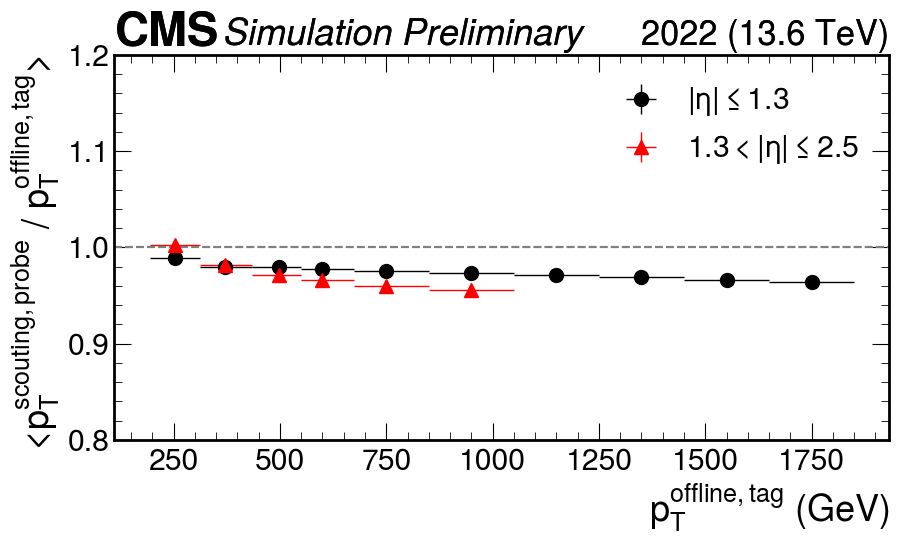

In [6]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

_rebin = {
    (85, 210): 4j,
    (210, 650) : 2j,
    (650, 2000) : 4j
}

centers = {
    0 : np.array([]),
    1 : np.array([])
}

means = {
    0 : np.array([]),
    1 : np.array([])
}

err = {
    0 : np.array([]),
    1 : np.array([])
}

etas = [0, 1]
for ieta in etas:
    for (lbin, rbin), nbin in _rebin.items():

        h = hs["h1"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h_centers = h.axes[0].centers

        for i, center in enumerate(h_centers):
            if (center < 80 and nbin == 1j) or (center > 1000 and ieta == 1) or (center < 160):
                continue

            h_i = h.copy()[{"pt" : i}]
            N = h_i.sum()
                
            centers[ieta] = np.concatenate((centers[ieta], [center]))
            means[ieta] = np.concatenate((means[ieta], [mean(h_i)]))
            err[ieta] = np.concatenate((err[ieta], [confidence(h_i) / np.sqrt(N)]))


for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': marker_eta[ieta],
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    _means = means[ieta]
    
    ax1.errorbar(
        centers[ieta],
        _means,
        xerr=[
            [np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 if i > 0 else np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 for i, _ in enumerate(centers[ieta])],
            [np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 if i < len(centers[ieta]) - 1 else np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 for i, _ in enumerate(centers[ieta])]
        ],
        yerr=err[ieta],
        **data_err_opts,
        label=label[ieta]
    )

    if isData:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary", lumi=34)
    else:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary",)
    ax1.set_xlabel(r"$p_T^{offline,tag}$ (GeV)")
    l = ax1.set_ylabel(r"<$p_T^{scouting,probe}$ / $p_T^{offline,tag}$>")
    ax1.axhline(1, color='gray',ls='--')
    ax1.set_ylim(0.8, 1.2)
    ax1.legend(loc="best")
    fig1.savefig("plots/JES_Eq1.pdf",
        bbox_extra_artists=(l, lh[0], lh[1]),
        bbox_inches='tight')

# Plot Eq. 2

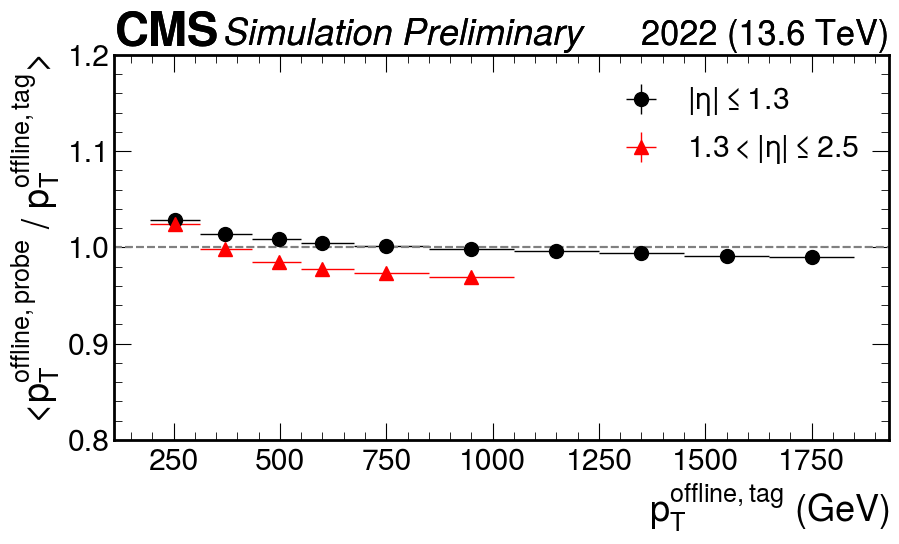

In [7]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

_rebin = {
    (85, 210): 4j,
    (210, 650) : 2j,
    (650, 2000) : 4j
}

centers = {
    0 : np.array([]),
    1 : np.array([])
}

means = {
    0 : np.array([]),
    1 : np.array([])
}

err = {
    0 : np.array([]),
    1 : np.array([])
}

etas = [0, 1]
for ieta in etas:
    for (lbin, rbin), nbin in _rebin.items():

        h = hs["h2"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h_centers = h.axes[0].centers

        for i, center in enumerate(h_centers):
            if (center < 80 and nbin == 1j) or (center > 1000 and ieta == 1)  or (center < 160):
                continue

            h_i = h.copy()[{"pt" : i}]
            N = h_i.sum()
                
            centers[ieta] = np.concatenate((centers[ieta], [center]))
            means[ieta] = np.concatenate((means[ieta], [mean(h_i)]))
            err[ieta] = np.concatenate((err[ieta], [confidence(h_i) / np.sqrt(N)]))


for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': marker_eta[ieta],
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    _means = means[ieta]
    
    ax1.errorbar(
        centers[ieta],
        _means,
        xerr=[
            [np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 if i > 0 else np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 for i, _ in enumerate(centers[ieta])],
            [np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 if i < len(centers[ieta]) - 1 else np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 for i, _ in enumerate(centers[ieta])]
        ],
        yerr=err[ieta],
        **data_err_opts,
        label=label[ieta]
    )

    if isData:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary", lumi=34)
    else:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary",)
    ax1.set_xlabel(r"$p_T^{offline,tag}$ (GeV)")
    l = ax1.set_ylabel(r"<$p_T^{offline,probe}$ / $p_T^{offline,tag}$>")
    ax1.axhline(1, color='gray',ls='--')
    ax1.set_ylim(0.8, 1.2)
    ax1.legend(loc="best")
    fig1.savefig("plots/JES_Eq2.pdf",
        bbox_extra_artists=(l, lh[0], lh[1]),
        bbox_inches='tight')

# Plot Eq. 1 / Eq. 2

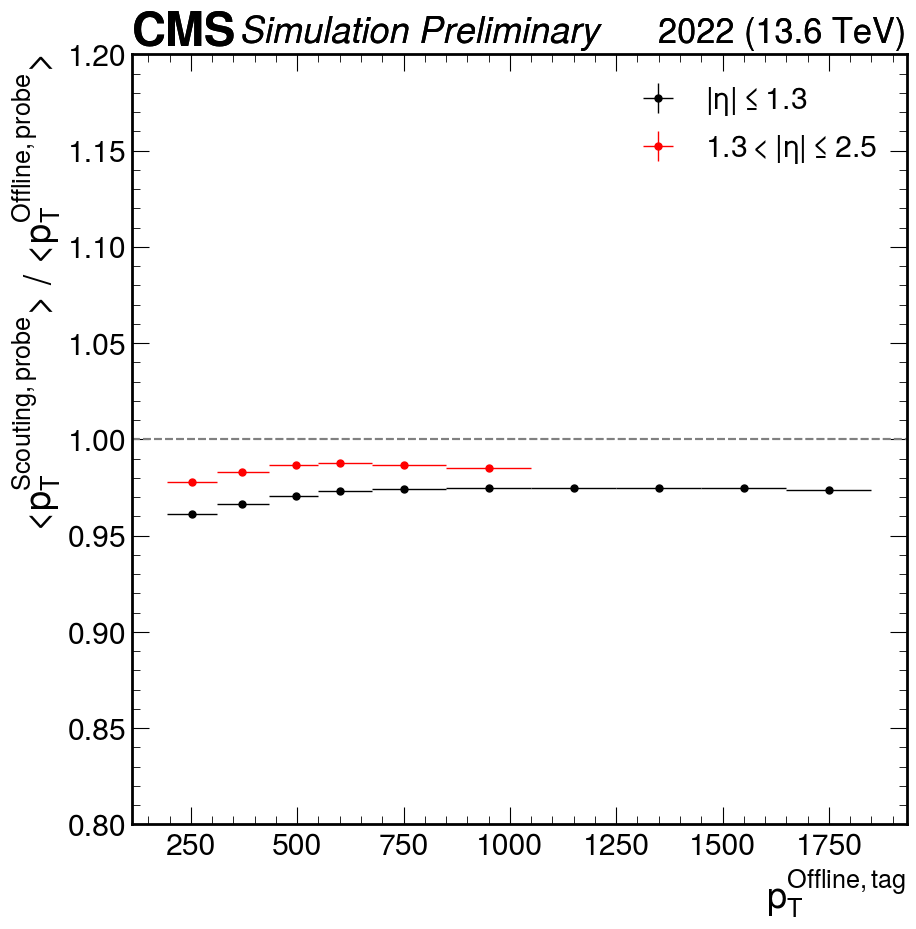

In [8]:
fig1, ax1 = plt.subplots(figsize=(10, 10))

_rebin = {
    (85, 210): 4j,
    (210, 650) : 2j,
    (650, 2000) : 4j
}

centers = {
    0 : np.array([]),
    1 : np.array([])
}

means = {
    "h1" : {
        0 : np.array([]),
        1 : np.array([])
    },
    "h2" : {
        0 : np.array([]),
        1 : np.array([])
    },
}

err = {
    0 : np.array([]),
    1 : np.array([])

}

etas = [0, 1]
for ieta in etas:
    for (lbin, rbin), nbin in _rebin.items():

        h1 = hs["h1"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h2 = hs["h2"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h3 = hs["h3"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h4 = hs["h4"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h_centers = h1.axes[0].centers

        for i, center in enumerate(h_centers):
            if (center < 80 and nbin == 1j) or (center > 1000 and ieta == 1)  or (center < 160):
                continue

            h1_i = h1.copy()[{"pt" : i}]
            h2_i = h2.copy()[{"pt" : i}]
            h3_i = h3.copy()[{"pt" : i}]
            N3 = h3_i.sum()
                
            centers[ieta] = np.concatenate((centers[ieta], [center]))
            means["h1"][ieta] = np.concatenate((means["h1"][ieta], [mean(h1_i)]))
            means["h2"][ieta] = np.concatenate((means["h2"][ieta], [mean(h2_i)]))
            err[ieta] = np.concatenate((err[ieta], [confidence(h3_i) / np.sqrt(N3)]))


for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    ax1.errorbar(
        centers[ieta],
        means["h1"][ieta] / means["h2"][ieta],
        xerr=[
            [np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 if i > 0 else np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 for i, _ in enumerate(centers[ieta])],
            [np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 if i < len(centers[ieta]) - 1 else np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 for i, _ in enumerate(centers[ieta])]
        ],
        yerr=err[ieta],
        **data_err_opts,
        label=label[ieta]
    )

    if isData:
        mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary", lumi=34)
    else:
        mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary",)
    ax1.set_xlabel(r"$p_T^{Offline,tag}$")
    ax1.set_ylabel(r"<$p_T^{Scouting,probe}$> / <$p_T^{Offline,probe}$>")
    ax1.axhline(1, color='gray',ls='--')
    ax1.set_ylim(0.8, 1.2)
    ax1.legend(loc="best")

# Plot Eq. 3

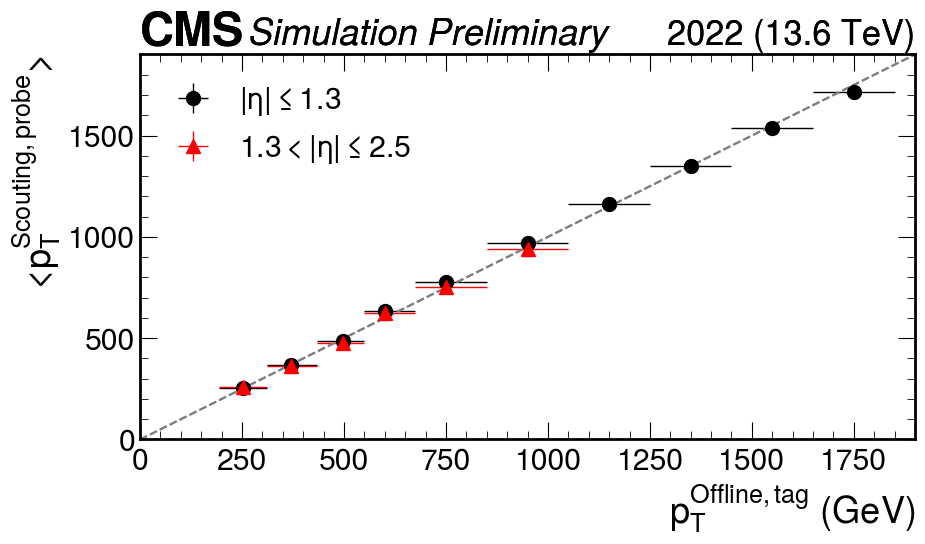

In [9]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

_rebin = {
    (85, 210): 4j,
    (210, 650) : 2j,
    (650, 2000) : 4j
}

centers = {
    0 : np.array([]),
    1 : np.array([])
}

means = {
    0 : np.array([]),
    1 : np.array([])
}

err = {
    0 : np.array([]),
    1 : np.array([])
}

etas = [0, 1]
for ieta in etas:
    for (lbin, rbin), nbin in _rebin.items():

        h = hs["h4"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h_centers = h.axes[0].centers

        for i, center in enumerate(h_centers):
            
#             print(i, center)
#             print(h)
            
            if (center < 80 and nbin == 1j) or (center > 1000 and ieta == 1)  or (center < 160):
                continue

            h_i = h.copy()[{"pt" : i}]
            N = h_i.sum()
                
            centers[ieta] = np.concatenate((centers[ieta], [center]))
            means[ieta] = np.concatenate((means[ieta], [mean(h_i)]))
            err[ieta] = np.concatenate((err[ieta], [confidence(h_i) / np.sqrt(N)]))


for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': marker_eta[ieta],
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    ax1.errorbar(
        centers[ieta],
        means[ieta],
        xerr=[
            [np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 if i > 0 else np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 for i, _ in enumerate(centers[ieta])],
            [np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 if i < len(centers[ieta]) - 1 else np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 for i, _ in enumerate(centers[ieta])]
        ],
        yerr=err[ieta],
        **data_err_opts,
        label=label[ieta]
    )

    if isData:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary", lumi=34)
    else:
        lh = mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, label="Preliminary",)
    ax1.set_xlabel(r"$p_T^{Offline,tag}$ (GeV)")
    l = ax1.set_ylabel(r"<$p_T^{Scouting,probe}$>")
    ax1.set_ylim(0, 1900)
    ax1.set_xlim(0, 1900)
    ax1.legend(loc="best")
    ax1.axline((0, 0), slope=1, color='gray',ls='--')
    fig1.savefig("plots/JES_Eq3.pdf",
        bbox_extra_artists=(l, lh[0], lh[1]),
        bbox_inches='tight')

# Plot final JES

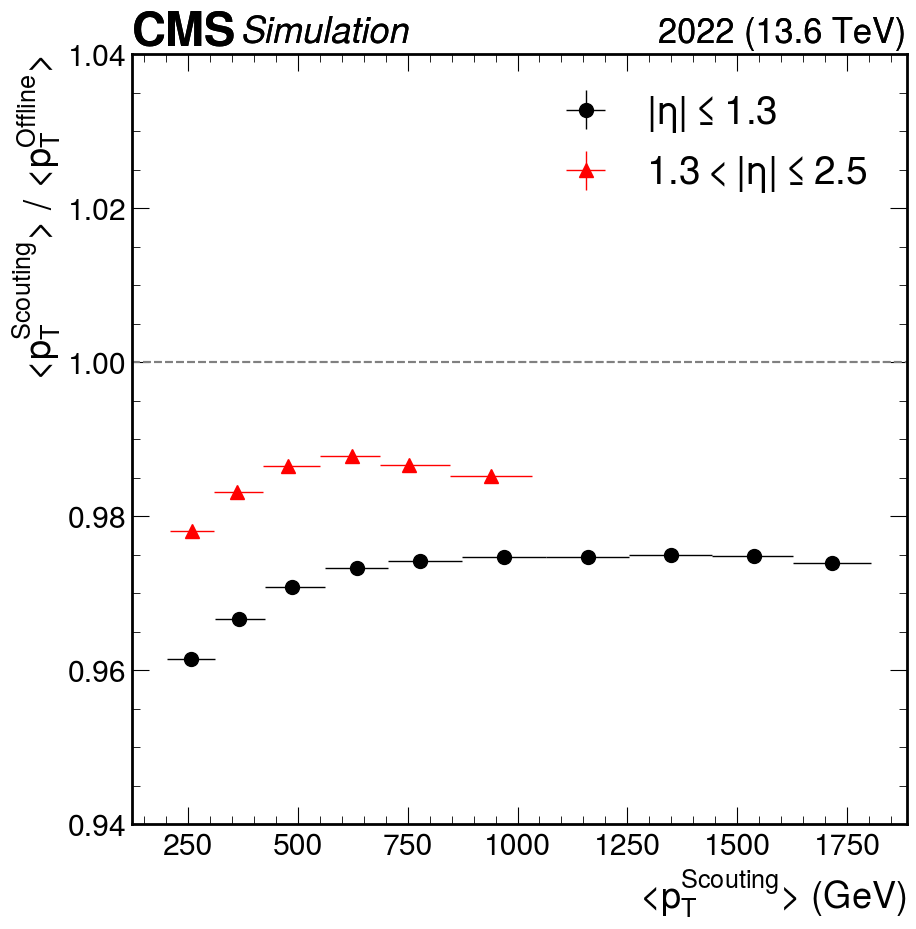

In [10]:
fig1, ax1 = plt.subplots(figsize=(10, 10))

_rebin = {
    (85, 210): 4j,
    (210, 650) : 2j,
    (650, 2000) : 4j
}

centers = {
    0 : np.array([]),
    1 : np.array([])
}

means = {
    "h1" : {
        0 : np.array([]),
        1 : np.array([])
    },
    "h2" : {
        0 : np.array([]),
        1 : np.array([])
    },
}

err = {
    0 : np.array([]),
    1 : np.array([])

}

etas = [0, 1]
for ieta in etas:
    for (lbin, rbin), nbin in _rebin.items():

        h1 = hs["h1"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h2 = hs["h2"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h3 = hs["h3"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h4 = hs["h4"][
            hist.loc(lbin):hist.loc(rbin):nbin,
            ieta,
            hist.loc(0):hist.loc(0.05):sum,
            hist.rebin(1)
        ]
        
        h_centers = h1.axes[0].centers

        for i, center in enumerate(h_centers):
            if (center < 80 and nbin == 1j) or (center > 1000 and ieta == 1)  or (center < 160):
                continue

            h1_i = h1.copy()[{"pt" : i}]
            h2_i = h2.copy()[{"pt" : i}]
            h3_i = h3.copy()[{"pt" : i}]
            h4_i = h4.copy()[{"pt" : i}]
            N3 = h3_i.sum()
                
            centers[ieta] = np.concatenate((centers[ieta], [mean(h4_i)]))
            means["h1"][ieta] = np.concatenate((means["h1"][ieta], [mean(h1_i)]))
            means["h2"][ieta] = np.concatenate((means["h2"][ieta], [mean(h2_i)]))
            err[ieta] = np.concatenate((err[ieta], [confidence(h3_i) / np.sqrt(N3)]))


for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': marker_eta[ieta],
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    ax1.errorbar(
        centers[ieta],
        means["h1"][ieta] / means["h2"][ieta],
        xerr=[
            [np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 if i > 0 else np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 for i, _ in enumerate(centers[ieta])],
            [np.abs(centers[ieta][i+1] - centers[ieta][i]) / 2 if i < len(centers[ieta]) - 1 else np.abs(centers[ieta][i] - centers[ieta][i-1]) / 2 for i, _ in enumerate(centers[ieta])]
        ],
        yerr=err[ieta],
        **data_err_opts,
        label=label[ieta]
    )

    if isData:
        mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6, lumi=34)
    else:
        mplhep.cms.label(ax=ax1, data=isData, year="2022", com=13.6)
#     ax1.set_xlabel(r"<$p_T^{Scouting,probe}$> (GeV)")
#     ax1.set_ylabel(r"<$p_T^{Scouting,probe}$> / <$p_T^{Offline,probe}$>")
    ax1.set_xlabel(r"<$p_T^{Scouting}$> (GeV)")
    ax1.set_ylabel(r"<$p_T^{Scouting}$> / <$p_T^{Offline}$>")
    ax1.axhline(1, color='gray',ls='--')
    ax1.set_ylim(0.94, 1.04)
    ax1.legend(loc="best", fontsize=28)
    
    fig1.savefig("plots/JES.pdf")

In [11]:
data = {
    "ratio" : {
        0 : means["h1"][0] / means["h2"][0],
        1 : means["h1"][1] / means["h2"][1],
    },
    "err" : {
        0 : err[0],
        1 : err[1],
    },
    "c" : {
        0 : centers[0],
        1 : centers[1],
    }
}

In [21]:
mc = {
    "ratio" : {
        0 : means["h1"][0] / means["h2"][0],
        1 : means["h1"][1] / means["h2"][1],
    },
    "err" : {
        0 : err[0],
        1 : err[1],
    },
    "c" : {
        0 : centers[0],
        1 : centers[1],
    }
}

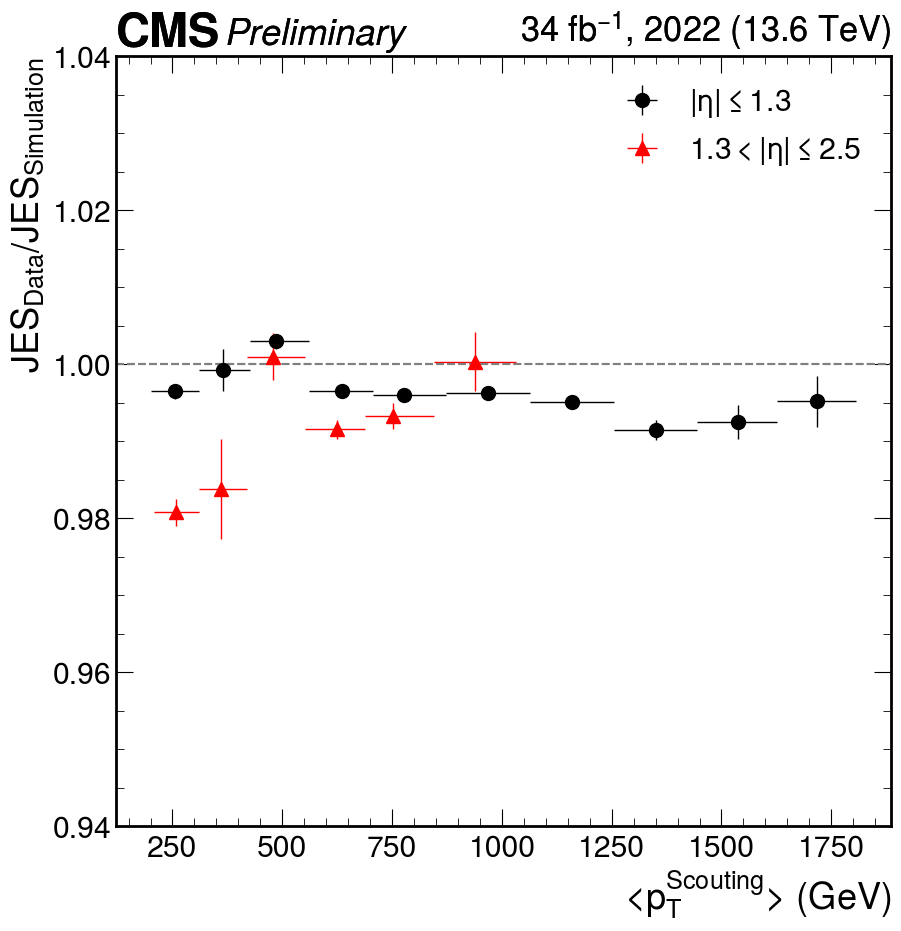

In [22]:
fig1, ax1 = plt.subplots(figsize=(10, 10))

for ieta in etas:
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': marker_eta[ieta],
        'markersize': 10.,
        'color': colours_eta[ieta],
        'elinewidth': 1,
    }
    
    centers = mc["c"][ieta]
    
    ax1.errorbar(
        centers,
        data["ratio"][ieta] / mc["ratio"][ieta],
        xerr=[
            [np.abs(centers[i] - centers[i-1]) / 2 if i > 0 else np.abs(centers[i+1] - centers[i]) / 2 for i, _ in enumerate(centers)],
            [np.abs(centers[i+1] - centers[i]) / 2 if i < len(centers) - 1 else np.abs(centers[i] - centers[i-1]) / 2 for i, _ in enumerate(centers)]
        ],
        yerr=err_prop(
            data["ratio"][ieta],
            mc["ratio"][ieta],
            data["err"][ieta],
            mc["err"][ieta],
        ),
        **data_err_opts,
        label=label[ieta]
    )

    mplhep.cms.label(ax=ax1, data=True, year="2022", com=13.6, label="Preliminary", lumi=34)
#     ax1.set_xlabel(r"<$p_T^{Scouting,probe}$> (GeV)")
    ax1.set_xlabel(r"<$p_T^{Scouting}$> (GeV)")
    ax1.set_ylabel(r"$JES_{Data} / JES_{Simulation}$")
    ax1.axhline(1, color='gray',ls='--')
    ax1.set_ylim(0.94, 1.04)
    ax1.legend(loc="best")
    
    fig1.savefig("plots/JES_ratio.pdf")